In [1]:
import os
from os import path
os.sys.path.append('../core/')
from mangle import *#cube_mangle
from astropy.io import fits
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from astropy.wcs import WCS
from copy import deepcopy
from calibrimbore.bill import get_skymapper_region
%matplotlib widget

from scipy.ndimage.filters import convolve
from scipy.ndimage import gaussian_filter
from copy import deepcopy

from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import pandas as pd
from astroquery.vizier import Vizier

from scipy.optimize import minimize
import astropy.table as at

def get_gaia_region(ra,dec,size=0.4, magnitude_limit = 21):
	"""
	Get the coordinates and mag of all gaia sources in the field of view.

	-------
	Inputs-
	-------
		tpf 				class 	target pixel file lightkurve class
		magnitude_limit 	float 	cutoff for Gaia sources
		Offset 				int 	offset for the boundary 
	
	--------
	Outputs-
	--------
		coords 	array	coordinates of sources
		Gmag 	array 	Gmags of sources
	"""
	c1 = SkyCoord(ra, dec, unit='deg')
	Vizier.ROW_LIMIT = -1

	result = Vizier.query_region(c1, catalog=["I/355/gaiadr3"],
                             		 radius=Angle(size, "arcsec"),column_filters={'Gmag':f'<{magnitude_limit}'})

	keys = ['objID','RAJ2000','DEJ2000','e_RAJ2000','e_DEJ2000','gmag','e_gmag','gKmag','e_gKmag','rmag',
			'e_rmag','rKmag','e_rKmag','imag','e_imag','iKmag','e_iKmag','zmag','e_zmag','zKmag','e_zKmag',
			'ymag','e_ymag','yKmag','e_yKmag','tmag','gaiaid','gaiamag','gaiadist','gaiadist_u','gaiadist_l',
			'row','col']


	no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
	if result is None:
		raise no_targets_found_message
	elif len(result) == 0:
		raise no_targets_found_message
	

	result = result['I/355/gaiadr3'].to_pandas()
	result = result.rename(columns={'RA_ICRS':'ra','DE_ICRS':'dec'})
	return result



/home/users/rri38/miniconda3/lib/python3.9/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/users/rri38/miniconda3/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
<ipython-input-1-159eab06a207>:18: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
hdul = fits.open('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')
wcs = WCS('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')

hdul = fits.open('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')
wcs = WCS('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
wcs = WCS(hdul[1].header)
data = hdul[1].data

In [4]:
ra,dec, lam = wcs.all_pix2world(data.shape[2]/2,data.shape[1]/2,100,0)

In [5]:
#cat = get_skymapper_region([ra],[dec],size=100)
cat = get_gaia_region([ra],[dec],size=50)

In [30]:
x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)

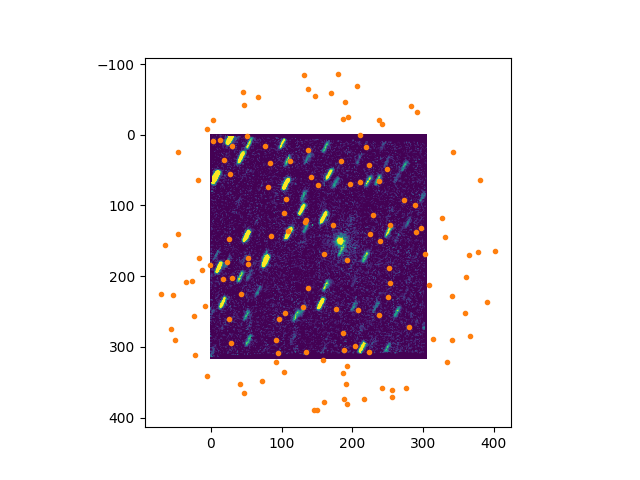

In [31]:
plt.figure()
plt.imshow(data[500],vmin=0,vmax=100)
plt.plot(x,y,'C1.')

In [33]:
image = np.nanmean(data,axis=0)
image[np.isnan(image)] = 0
image = gaussian_filter(image,3)

In [34]:
n_head = deepcopy(hdul[1].header)
n_head['NAXIS'] = 2
del n_head['C*']
del n_head['NAXIS3']
del n_head['BUNIT']


In [35]:
fits.writeto('test.fits',image,header=n_head,overwrite=True)

In [39]:
tmp = os.environ['TMPDIR']
name = 'wcs/test_wcs'
inter = 'test.fits'
astrom_call = f"solve-field --no-plots --scale-units arcminwidth --scale-low 0.9 --scale-high 1.1 --temp-dir {tmp} -O -o {name} -p --ra {ra} --dec {dec} --radius 0.2 {inter}"

os.system(astrom_call)

0

In [38]:
astrom_call

'solve-field --no-plots --scale-units arcminwidth --scale-low 0.9 --scale-high 1.1 --temp-dir /scratch/rri38/ -O -o wcs/test_wcs -p --ra 192.8664491943306 --dec -69.13479926066692 --radius 0.2 test.fits'

In [40]:
#mean, med, std = sigma_clipped_stats(image, sigma=3.0)
#daofind = DAOStarFinder(fwhm=1.0, threshold=1,exclude_border=True)
#s = daofind(image - med).to_pandas()
astrom = fits.open('wcs/test_wcs.axy')[1].data

In [41]:
sourcex = astrom['X']; sourcey = astrom['Y']
i = 20
buffer = 4
lowy = int(sourcey[i]-buffer)
highy = int(sourcey[i]+buffer+1)
lowx = int(sourcex[i]-buffer)
highx = int(sourcex[i]+buffer+1)
if lowy < 0:
    lowy = 0
if lowx < 0:
    lowx = 0
thing = image[lowy:highy,lowx:highx]

np.where(thing == np.nanmax(thing))

(array([3]), array([3]))

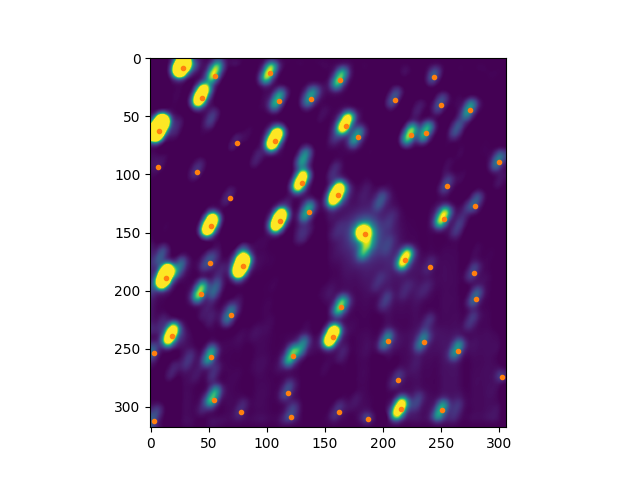

In [42]:
plt.figure()
plt.imshow(image,vmin=0,vmax=50)
#plt.plot(s.xcentroid.values,s.ycentroid.values,'.')
plt.plot(astrom['X'],astrom['Y'],'C1.')

In [43]:
def min_dist(x1,y1,x2,y2):
    dx = x1[:,np.newaxis] - x2[np.newaxis,:]
    dy = y1[:,np.newaxis] - y2[np.newaxis,:]
    d = np.sqrt(dx**2 + dy**2)
    md = np.nanmin(d,axis=1)
    return md

def minimize_dist(offset,x1,y1,x2,y2,image):
    cx = image.shape[1]/2; cy = image.shape[0]/2
    x = x1 + offset[0]
    y = y1 + offset[1]
    x = cx + ((x-cx)*np.cos(offset[2])-(y-cy)*np.sin(offset[2]))
    y = cy + ((x-cx)*np.sin(offset[2])+(y-cy)*np.cos(offset[2]))

    ind = (x > 0) & (x < image.shape[1]) & (y > 0) & (y < image.shape[0])
    x = x[ind]; y = y[ind]
    mdist = min_dist(x2,y2,x,y)
    return np.nanmean(mdist)

x0 = [0,0,0]

ind = cat['Gmag'].values < 20

x, y, lam = wcs.all_world2pix(cat.ra.values[ind],cat.dec.values[ind],0,0)

catx = x; caty = y
sourcex = astrom['X']; sourcey = astrom['Y']

res = minimize(minimize_dist,x0,args=(catx,caty,sourcex,sourcey,image))

xx = x + res.x[0]
yy = y + res.x[1]
cx = image.shape[1]/2; cy = image.shape[0]/2
xx = cx + ((xx-cx)*np.cos(res.x[2])-(yy-cy)*np.sin(res.x[2]))
yy = cy + ((xx-cx)*np.sin(res.x[2])+(yy-cy)*np.cos(res.x[2]))

#ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
#xx = xx[ind]; yy = yy[ind]

cut = min_dist(xx,yy,sourcex,sourcey) < 5
print('round 1: ',res.x)
res = minimize(minimize_dist,x0,args=(catx[cut],caty[cut],sourcex,sourcey,image))
print('round 2: ',res.x)


round 1:  [-7.78457066  3.03998591 -0.34310449]
round 2:  [ 60.0363025  -79.43936703   1.66591133]


<ipython-input-44-74fad1cf6af7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaia['x'] = xx
<ipython-input-44-74fad1cf6af7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaia['y'] = yy


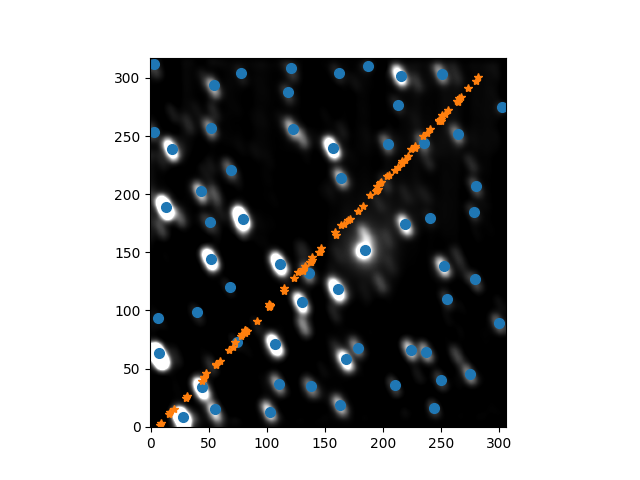

In [44]:
x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)
xx = x + res.x[0]
yy = y + res.x[1]
cx = image.shape[1]/2; cy = image.shape[0]/2
xx = cx + ((xx-cx)*np.cos(res.x[2])-(yy-cy)*np.sin(res.x[2]))
yy = cy + ((xx-cx)*np.sin(res.x[2])+(yy-cy)*np.cos(res.x[2]))

ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
xx = xx[ind]; yy = yy[ind]
gaia = cat.iloc[ind]
gaia['x'] = xx
gaia['y'] = yy

plt.figure()
plt.imshow(image,vmin=0,vmax=50,cmap='gray',origin='lower')
plt.plot(astrom['X'],astrom['Y'],'o',ms=7)
plt.plot(xx,yy,'C1*')


In [17]:
G = gaia['Gmag'].values
B = gaia['BPmag'].values
R = gaia['RPmag'].values

gbp = G - B
grp = G - R
bprp = B - R

In [18]:
syn = pd.read_csv('ckmodel_Gaia_colors.csv')

In [19]:
diff = np.sqrt((gbp[:,np.newaxis] - syn['G-Bp'].values[np.newaxis,:])**2 + (grp[:,np.newaxis] - syn['G-Rp'].values[np.newaxis,:])**2 + (bprp[:,np.newaxis] - syn['Bp-Rp'].values[np.newaxis,:])**2)

In [20]:
inds = np.argmin(diff,axis=1)

In [21]:
matched = syn.iloc[inds]

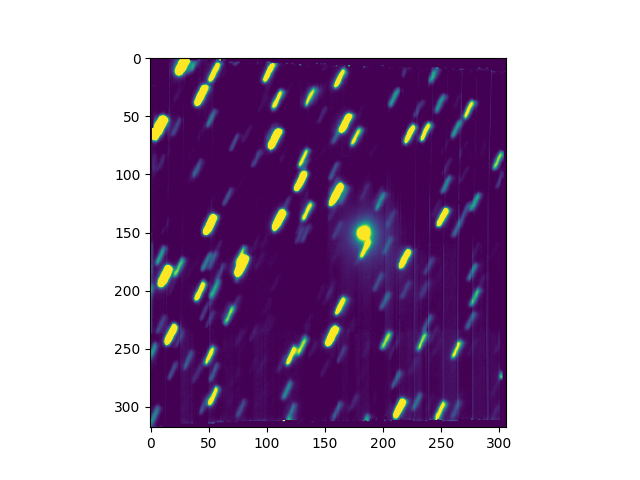

In [32]:
plt.figure()
plt.imshow(np.nanmean(data,axis=0),vmin=0,vmax=50)


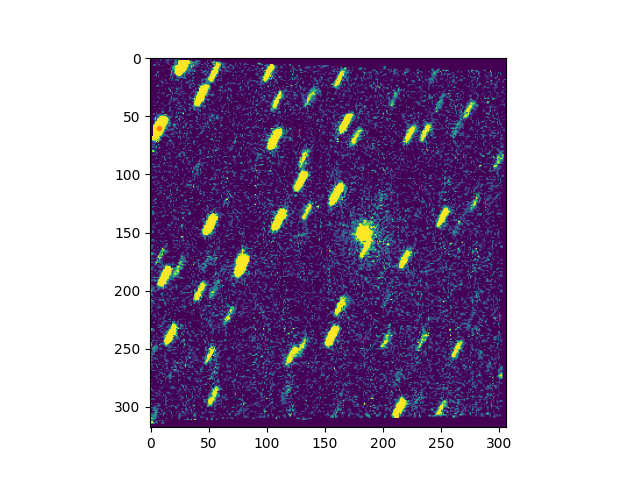

In [22]:
ind = np.argmin(gaia['Gmag'].values)
plt.figure()
plt.imshow(data[500],vmin=0,vmax=50)
plt.plot(int(gaia['x'].values[ind]),int(gaia['y'].values[ind]),'C1.')

In [23]:
ck = at.Table.read('/home/phys/astronomy/rri38/cube_scene/core/data/ck_spec/'+matched.iloc[ind]['model'], format='ascii')

In [24]:
x,y,lam = wcs.all_pix2world(0,0,np.arange(0,len(data)),0)

(3750.21533203125, 10350.21533203125)

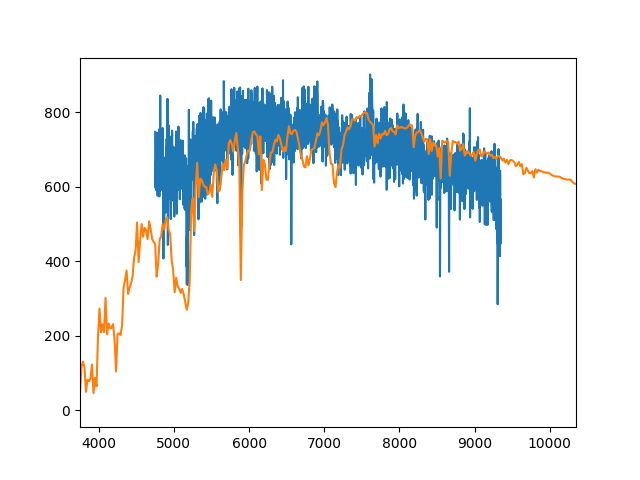

In [25]:
plt.figure()
plt.plot(lam*1e10,data[:,int(gaia['y'].values[58]),int(gaia['x'].values[58])])
plt.plot(ck['wave'],ck['flux']/np.nanmax(ck['flux'])*800)
plt.xlim(min(lam*1e10)-1000,max(lam*1e10)+1000)

In [26]:
mags = np.array([B,G,R]).T

In [27]:
cube_mangle(matched['model'].values,mags)

SVO
SVO
SVO
OrderedDict([('GAIA/GAIA3.Gbp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701e0460>, -2.094986479118612e+01)), ('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86702590d0>, -21.375993149393477)), ('GAIA/GAIA3.Grp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701ee100>, -21.859714513454705))])
[      nan 20.702034       nan]
1221
[nan nan nan ... nan nan nan]
OrderedDict([('GAIA/GAIA3.Gbp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701e0460>, -20.94986479118612)), ('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86702590d0>, -21.375993149393477)), ('GAIA/GAIA3.Grp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701ee100>, -21.859714513454705))])
[17.580181 16.921877 16.138477]
1221
(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.53583573e-23, 3.52062488e-23, 2.05931175e-23]]), {'allbands': None, 'ave_waves': None, 'bands': ['GAIA/GAIA3.Gbp', 'GAIA

ValueError: wave and flux arrays must be of equal length

In [ ]:
mags[i,1]

16.921877

In [ ]:
def Syn_mag(pbs,spec):
    mag = {}
    for pb in pbs:
        if spec is not None:
            syn_mag = synphot(spec,pbs[pb][0],zp=pbs[pb][1])
        else:
            syn_mag = np.nan
        mag[pb] = syn_mag
        
    return mag

def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    m = Syn_mag(pbs,spec)
    m=m['GAIA/GAIA3.G']
    factor = 10**(-2/5*(mag-m))
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec

In [ ]:
spec_files = matched['model'].values


svo_bp=['GAIA/GAIA3.G']

pbs = load_pbs(svo_bp,0,'AB',SVO=True)
mangled = []
for i in range(2):
    spec = at.Table.read(package_dir + spec_files[i], format='ascii')
    spec = S.ArraySpectrum(wave=spec['wave'].value,
                                    flux=spec['flux'].value,fluxunits='flam')
    print(pbs)
    print(mags[i])
    if np.isfinite(mags[i]).all():
        #flux = mangle_spectrum2(spec.wave,spec.flux,pbs,np.array([mags[i,1]]))
        spec2 = my_norm(spec,pbs,np.array([mags[i,1]]))
    else:
        flux = spec.flux * np.nan
    print(len(spec.wave))
    print(flux)

    #spec2 = S.ArraySpectrum(wave=spec.wave,
     #                               flux=flux,fluxunits='flam')
    mangled += [spec2]

SVO
OrderedDict([('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7fc61af039d0>, -21.375993149393477))])
[      nan 20.702034       nan]
1221
[nan nan nan ... nan nan nan]
OrderedDict([('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7fc61af039d0>, -21.375993149393477))])
[17.580181 16.921877 16.138477]
1221
[nan nan nan ... nan nan nan]


In [ ]:
spec2.flux

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.28026005e-23, 1.22829591e-23, 7.18464555e-24])

In [ ]:
spec.flux

array([0.      , 0.      , 0.      , ..., 0.037838, 0.020382, 0.011922])

In [ ]:
pbs

OrderedDict([('GAIA/GAIA3.Gbp',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc6e90de790>,
               -20.94986479118612)),
             ('GAIA/GAIA3.G',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc61bea6df0>,
               -21.375993149393477)),
             ('GAIA/GAIA3.Grp',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc61be8c700>,
               -21.859714513454705))])

In [37]:
mags[i]

array([17.580181, 16.921877, 16.138477])

In [38]:
flux

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.53583573e-23, 3.52062488e-23, 2.05931175e-23]]),
 {'allbands': None,
  'ave_waves': None,
  'bands': ['GAIA/GAIA3.Gbp', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Grp'],
  'resp_rats': None,
  'mfactors': None},
 array([ 1.43240369, -1.0271856 ,  1.37540149]))

In [65]:
spec2.fluxunits

(3750.21533203125, 10350.21533203125)

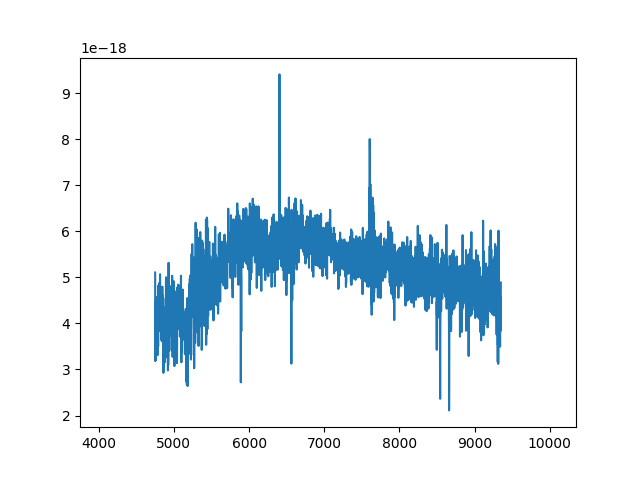

In [74]:
plt.figure()
plt.plot(lam*1e10,data[:,int(gaia['y'].values[1]),int(gaia['x'].values[1])]*10**-20)
plt.plot(spec2.wave,spec2.flux)
#plt.plot(spec.wave,spec.flux)

#plt.plot(ck['wave'],ck['flux']/np.nanmax(ck['flux'])*800)
plt.xlim(min(lam*1e10)-1000,max(lam*1e10)+1000)

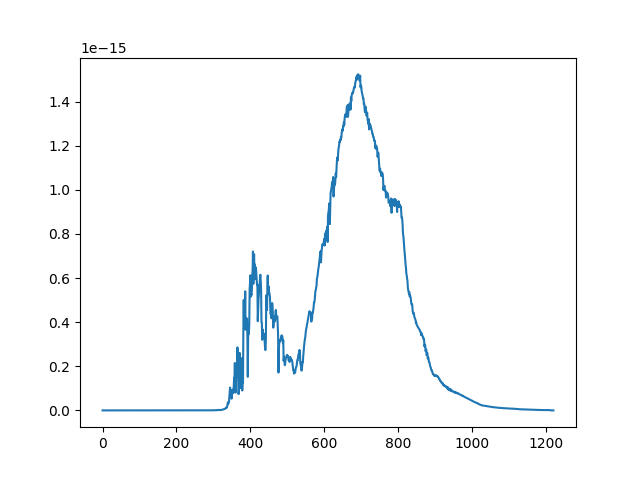

In [32]:
plt.figure()
plt.plot(flux[0][0])

In [266]:
G = cat['Gmag'].values
B = cat['BPmag'].values
R = cat['RPmag'].values

In [1]:
wcs

NameError: name 'wcs' is not defined

In [26]:
ck['wave'].value

array([9.09000015e+01, 9.35000000e+01, 9.60999985e+01, ...,
       1.20000000e+06, 1.40000000e+06, 1.60000000e+06])

In [69]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-04-14T12:21:53' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U4'         / ESO <TEL>                                      
INSTRUME= 'MUSE    '           / Instrument used.                               
RA      =           192.866371 / [deg] 12:51:27.9 RA (J2000) pointing           
DEC     =            -69.13484 / [deg] -69:08:05.4 DEC (J2000) pointing         
EQUINOX =                200